# QUESTIONS: 
How to investigate the SVD of the Radon transform?
What projection values to select for the part 1?
How to relate the noise?
How many values to select for the part 2?
   

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astra

In [3]:
# Load the image Slphan.npy
f_true = np.load('SLphan.npy')

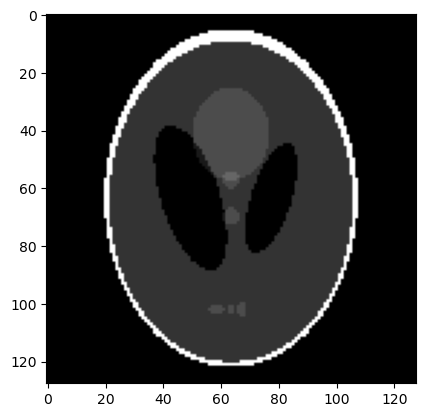

In [4]:
# Display the image
plt.imshow(f_true, cmap='gray')
plt.show()

In [5]:
# Create volume geometries
v, h = f_true.shape
vol_geom = astra.create_vol_geom(v, h)

In [6]:
# Create projection geometries
angles = np.linspace(0, np.pi, 180, False)
proj_geom = astra.create_proj_geom('parallel', 1.0, h, angles)

In [7]:
proj_id = astra.create_projector('strip', proj_geom, vol_geom)
# Create sinogram
sinogram_id, sinogram = astra.create_sino(f_true, proj_id)

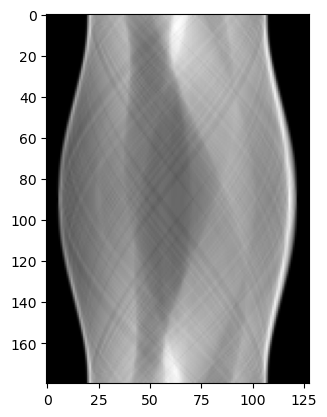

In [8]:
plt.imshow(sinogram, cmap='gray')
plt.show()

In [9]:
rec_id = astra.data2d.create('-vol', vol_geom)

In [10]:
cfg = astra.astra_dict('BP')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id

In [11]:
alg_id = astra.algorithm.create(cfg)

In [12]:
# Run the algorithm
astra.algorithm.run(alg_id)
f_rec = astra.data2d.get(rec_id)

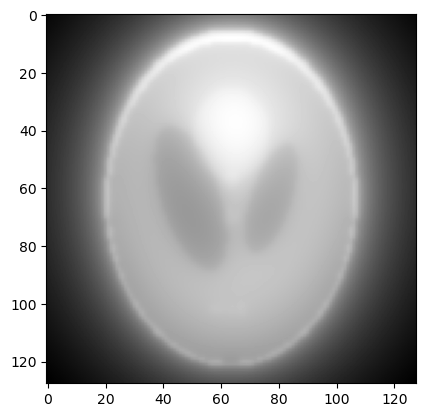

In [13]:
plt.imshow(f_rec, cmap='gray')
plt.show()

In [14]:
cfg = astra.astra_dict('FBP')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id

In [15]:
alg_id = astra.algorithm.create(cfg)
# Run the algorithm
astra.algorithm.run(alg_id)
f_rec_2 = astra.data2d.get(rec_id)


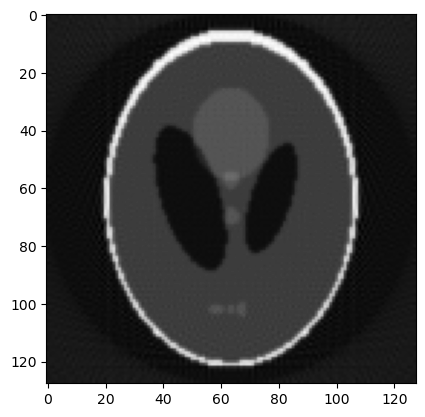

In [16]:
plt.imshow(f_rec_2, cmap='gray')
plt.show()

In [17]:
gNoisy = astra.functions.add_noise_to_sino(sinogram, 1000)
gNoisy_id = astra.data2d.create('-sino', proj_geom, gNoisy)

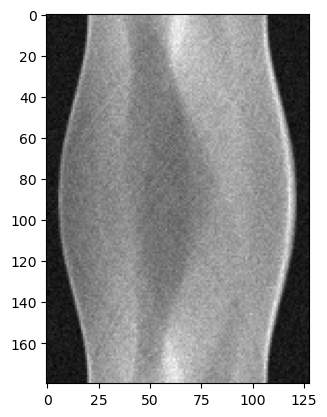

In [18]:
plt.imshow(gNoisy, cmap='gray')
plt.show()


In [19]:
cfg = astra.astra_dict('FBP')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = gNoisy_id
cfg['ProjectorId'] = proj_id

In [20]:
alg_id = astra.algorithm.create(cfg)

In [21]:
astra.algorithm.run(alg_id)
f_rec_3 = astra.data2d.get(rec_id)

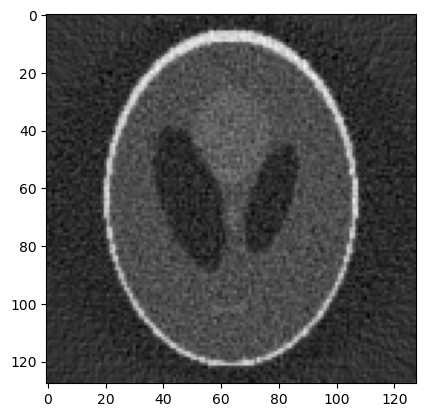

In [22]:
plt.imshow(f_rec_3, cmap='gray')
plt.show()

Calculate the error in the reconstruction by finding the norm of the difference between the true image and the reconstructed image

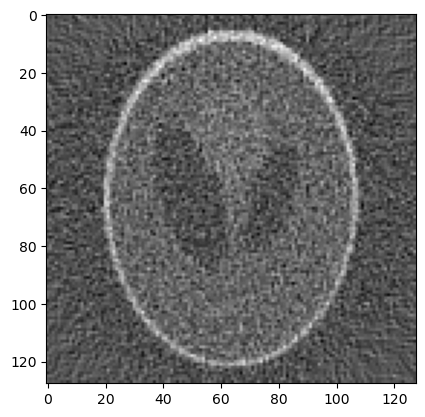

In [23]:
Noisy = astra.functions.add_noise_to_sino(sinogram, 100)
gNoisy_id = astra.data2d.create('-sino', proj_geom, Noisy)

cfg = astra.astra_dict('FBP')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = gNoisy_id
cfg['ProjectorId'] = proj_id
alg_id = astra.algorithm.create(cfg)
astra.algorithm.run(alg_id)
f_rec_4 = astra.data2d.get(rec_id)
plt.imshow(f_rec_4, cmap='gray')
plt.show()

In [24]:
error_0 = np.linalg.norm(f_true - f_rec_2)
error_1 = np.linalg.norm(f_true - f_rec_3)
error_2 = np.linalg.norm(f_true - f_rec_4)
print("The error with the FBP algorithm (noiseless) is: ", error_0)
print("The error with the FBP algorithm (noise = 1000) is: ", error_1)
print("The error with the FBP algorithm (noise = 10) is: ", error_2)

The error with the FBP algorithm (noiseless) is:  7.360654316889076
The error with the FBP algorithm (noise = 1000) is:  10.870413143597359
The error with the FBP algorithm (noise = 10) is:  26.630322477430163


Part 2. Calculate an explicit matrix form of the Radon transform and investigate its SVD.

In [30]:
# Create a zero matrix with 4050 rows and 4096 columns
A = np.zeros((4050, 4096))
vol_geom2 = astra.create_vol_geom(64, 64)
# Create projection geometries
angles2 = np.linspace(0,np.pi,45,endpoint=False)
proj_geom2 = astra.create_proj_geom('parallel', 1.0, 90, angles2)
proj_id2 = astra.create_projector('strip', proj_geom2, vol_geom2)
for i in range(4096):
    # Create a 64x64 matrix with a 1 in the i-th element
    f = np.zeros(4096)
    f[i] = 1
    f = f.reshape((64, 64))
    # Create sinogram
    sinogram_id, sinogram = astra.create_sino(f, proj_id2)
    # Reshape the sinogram to a 1D array and store it in the i-th column of A
    A[:, i] = sinogram.reshape(4050)

In [31]:
# Calculate the SVD of A
U, S, V = np.linalg.svd(A)
